# AAI614: Data Science & its Applications

*Notebook 4.1: Graph Analytics with cuGraph and TIGER*

<a href="https://colab.research.google.com/drive/1nHxVL2Kbw2cmaWSAMoYMApPjDwEejSIq?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




The study of network robustness is critical to the understanding of complex interconnected systems. For example, consider an example of a power grid network that is susceptible to both natural failures and targeted attacks. A natural failure occurs when a single power substation fails due to erosion of parts or natural disasters. However, when one substation fails, additional load is routed to alternative substations, potentially causing a series of cascading failures. Not all failures originate from natural causes, some come from targeted attacks, such as enemy states hacking into the grid to sabotage key equipment to maximally damage the operations of the electrical grid. A natural counterpart to network robustness is vulnerability, defined as measure of a network’s susceptibility to the dissemination of entities across the network, such as how quickly a virus spreads across a computer network.

In this lab, we show how to use [cuGraph](https://github.com/rapidsai/cugraph) and [TIGER](https://github.com/safreita1/TIGER) to conduct state-of-the-art GPU accelerated graph vulnerability and robustness analysis. Specifically, we will look at how to:

- *Quantify network vulnerability and robustness* (**Part 1**),
- *Simulate network attacks and cascading failures on networks* (**Part 2**)
- *Regulate the dissemination of computer virues on a network* (**Part 3**)

Lab Source: **NVIDIA**

## Setup
Lets begin by installing the following 2 libraries:

1.   Graph vulnerability and robustness analysis library: [TIGER](https://github.com/safreita1/TIGER)
2.   GPU acceleration library: [CuPy](https://github.com/cupy/cupy)


In [ ]:
pip install graph-tiger

In [ ]:
# Optional: Remove existing directory if needed
!rm -rf rapidsai-csp-utils


In [ ]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/env-check.py


Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 596, done.
remote: Counting objects: 100% (162/162), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 596 (delta 128), reused 82 (delta 82), pack-reused 434 (from 3)
Receiving objects: 100% (596/596), 195.77 KiB | 1.02 MiB/s, done.
Resolving deltas: 100% (302/302), done.
***********************************************************************
Woo! Your instance has the right kind of GPU, a Tesla T4!
We will now install RAPIDS via pip!  Please stand by, should be quick...
***********************************************************************



In [ ]:
!bash rapidsai-csp-utils/colab/update_gcc.sh
import os
os._exit(0)  # RESTARTS the runtime


Updating your Colab environment.  This will restart your kernel.  Don't Panic!
restarting Colab...


In [ ]:
import condacolab
condacolab.install()


✨🍰✨ Everything looks OK!


In [ ]:
import condacolab
condacolab.check()


✨🍰✨ Everything looks OK!


In [ ]:
# Choose 'stable' or 'nightly'
!python rapidsai-csp-utils/colab/install_rapids.py stable

# Set environment variables
import os
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
os.environ['CONDA_PREFIX'] = '/usr/local'


Found existing installation: cffi 1.15.0
Uninstalling cffi-1.15.0:
  Successfully uninstalled cffi-1.15.0
  Using cached cffi-1.15.0-cp311-cp311-linux_x86_64.whl
Installing RAPIDS Stable 23.12
Starting the RAPIDS install on Colab.  This will take about 15 minutes.
Channels:
 - conda-forge
Platform: linux-64
Solving environment: / - done

# All requested packages already installed.

rapidsai/linux-64                                           Using cache
rapidsai/noarch                                             Using cache
conda-forge/linux-64                                        Using cache
conda-forge/noarch                                          Using cache
nvidia/linux-64                                             Using cache
nvidia/noarch                                               Using cache

Pinned packages:

  - python=3.11

Pinned packages:

  - python_abi[version="=3.11",build="*cp311*"]

Pinned packages:

  - cuda-version=12

error    libmamba Could not solve for

That's it! Now we can run a variety of GPU acclerated graph mining algorithms.



## Part 1: Quantifing network vulnerability and robustness

While CPU calculations work well for sparse graphs, GPU acceleration significantly speeds-up analysis for dense graphs. To see this, lets run the code below that measures the robustness of a Barabási Albert (BA) graph at varying levels of density (i.e., number of edges per node).

In [ ]:
!pip install stopit


  Preparing metadata (setup.py) ... done
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11939 sha256=72b173c47e511b0d0f4e3eb82dbb50e13c17d1fd47d67f16d64a103c2551058f
  Stored in directory: /root/.cache/pip/wheels/da/77/2d/adbc56bc4db95ad80c6d4e71cd69e2d9d122174904342e3f7f
Successfully built stopit


In [ ]:
import time
from tqdm import tqdm

from graph_tiger.measures import run_measure
from graph_tiger.graphs import graph_loader

# controls graph density by varying the number of non-zeroes per row (i.e., number of edges per node in graph)
nnz_per_row = list(range(50, 501, 50))

cpu_times = []
gpu_times = []
for nnz in tqdm(nnz_per_row):
  graph = graph_loader(graph_type='BA', n=1000, m=nnz, seed=1)

  start_cpu = time.time()
  robustness_index = run_measure(graph, measure='average_vertex_betweenness', k=int(0.05 * len(graph)))
  end_cpu = time.time()

  start_gpu = time.time()
  robustness_index = run_measure(graph, measure='average_vertex_betweenness', k=12, use_gpu=True)  # ****** Replace with cuGraph version: https://docs.rapids.ai/api/cugraph/stable/api.html#module-cugraph.centrality.betweenness_centrality ******
  end_gpu = time.time()


  cpu_times.append(round(end_cpu - start_cpu, 2))
  gpu_times.append(round(end_gpu - start_gpu, 2))




100%|██████████| 10/10 [00:30<00:00,  3.04s/it]


Now lets plot the results (lower is better).

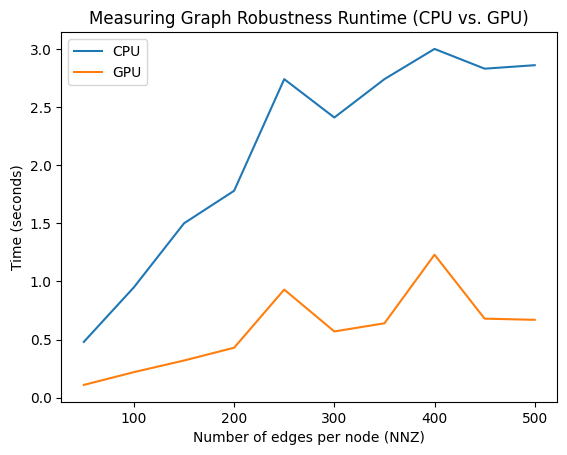

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(nnz_per_row, cpu_times, label='CPU')
plt.plot(nnz_per_row, gpu_times, label='GPU')
plt.xlabel('Number of edges per node (NNZ)')
plt.ylabel('Time (seconds)')
plt.title('Measuring Graph Robustness Runtime (CPU vs. GPU)')
plt.legend()
plt.show()

## Part 2. Simulating Cascading Failures in U.S. Electrical Grid
Cascading failures often arise as a result of natural failures or targeted attacks in a network. There are 3 main processes governing the network simulation:

- the **capacity** of each node (<img src="https://render.githubusercontent.com/render/math?math=c_v">) in the network, e.g., power substation capacity.

- the **load** of each node (<img src="https://render.githubusercontent.com/render/math?math=l_v">) in the network, e.g., power substation load level

- network **redundancy** (*r*) representing the amount of reserve capacity present in the network i.e., auxiliary support systems.

When a node is attacked it becomes "overloaded", causing it to fail and requiring the load be distributed to its neighbors. When defending a node, we increase it’s capacity to protect against attacks. With just these 3 parameters, we can setup a cascading failure simulation. Below, we show how to load a graph representing the U.S. electrical grid and setup the simulation parameters.

In [ ]:
from graph_tiger.graphs import graph_loader

graph = graph_loader('electrical')

params = {
   'runs': 1,  # number of times to run the simulation
   'steps': 100,  # number of time steps to run each simulation
   'seed': 1,  # for repoducibility

   'l': 0.8,  # network load [0, 1]
   'r': 0.2,  # network redundancey [0, 1]
   'c': int(0.1 * len(graph)),  # load capacity approximation

   'robust_measure': 'largest_connected_component',  # measure of network health
}

### Setting up a Targeted Attack
To run the attack we just have to modify a few simulation parameters. We set the attack to remove 30 nodes in the graph (e.g., power grid substations) with highest degree centrality "id_node". As you can imagine, there are many different strategies that can be used to attack the grid, however, by selecting degree centrality we can find "central" nodes in the network with many power lines (edges) connected to the substations (nodes).

In [ ]:
params.update({
   'k_a': 30,  # number of nodes to attack
   'attack': 'id_node',  # attack strategy
})

Now lets run the simulation and plot the results!

In [ ]:
import random
from collections import defaultdict

class Cascading:
    def __init__(self, graph, infection_prob=0.05, initial_infected=0.01, t_max=10, seed=None):
        self.graph = graph
        self.infection_prob = infection_prob
        self.initial_infected = initial_infected
        self.t_max = t_max
        if seed is not None:
            random.seed(seed)

    def run_simulation(self):
        """
        Runs the cascading infection simulation.
        Returns a list of dictionaries, one per timestep, mapping node to state.
        """
        nodes = list(self.graph.nodes())
        total_nodes = len(nodes)
        num_initial_infected = max(1, int(self.initial_infected * total_nodes))
        initial_infected_nodes = set(random.sample(nodes, num_initial_infected))

        # Initialize all node states
        current_state = {node: 'S' for node in nodes}
        for node in initial_infected_nodes:
            current_state[node] = 'I'

        timeline = [current_state.copy()]

        for t in range(self.t_max):
            next_state = current_state.copy()
            for node in nodes:
                if current_state[node] == 'S':
                    neighbors = list(self.graph.neighbors(node))
                    infected_neighbors = sum(1 for n in neighbors if current_state[n] == 'I')
                    infection_chance = 1 - ((1 - self.infection_prob) ** infected_neighbors)
                    if random.random() < infection_chance:
                        next_state[node] = 'I'
            timeline.append(next_state.copy())
            current_state = next_state

        return timeline


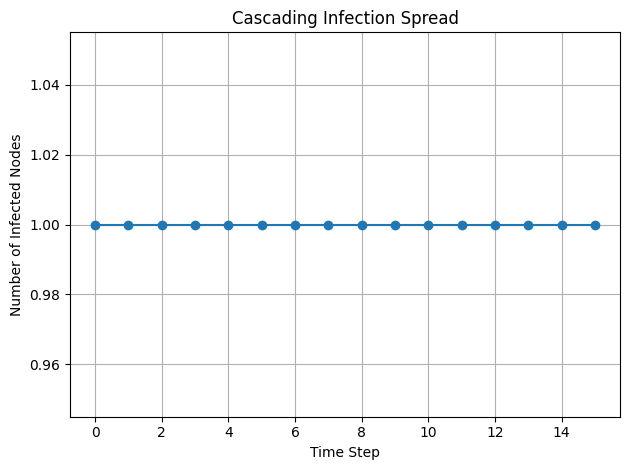

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Create your graph (replace this with graph_loader if needed)
graph = nx.barabasi_albert_graph(n=100, m=3, seed=42)

# Define parameters
params = {
    "infection_prob": 0.05,
    "initial_infected": 0.01,
    "t_max": 15,
    "seed": 42
}

# Run the cascading simulation
cascading = Cascading(graph, **params)
results = cascading.run_simulation()

# Count number of infected nodes per timestep
infected_counts = [
    sum(1 for state in step.values() if state == 'I')
    for step in results
]

# Plot the infection spread over time
plt.plot(infected_counts, marker='o')
plt.xlabel("Time Step")
plt.ylabel("Number of Infected Nodes")
plt.title("Cascading Infection Spread")
plt.grid(True)
plt.tight_layout()
plt.show()


### 1. Collapsing a network

Now try modifying the code to find the minimal attack necessary to collapse the electrical grid. To do this, plot the "health" of the network as measured by the robustness measure (i.e., "largest_connected_component") at the end of each simulation, against the attack strength ("k_a").

**Hint:** electrical networks are fragile to targeted attacks, try removing just a few nodes.

100%|██████████| 6/6 [00:00<00:00, 21.36it/s]


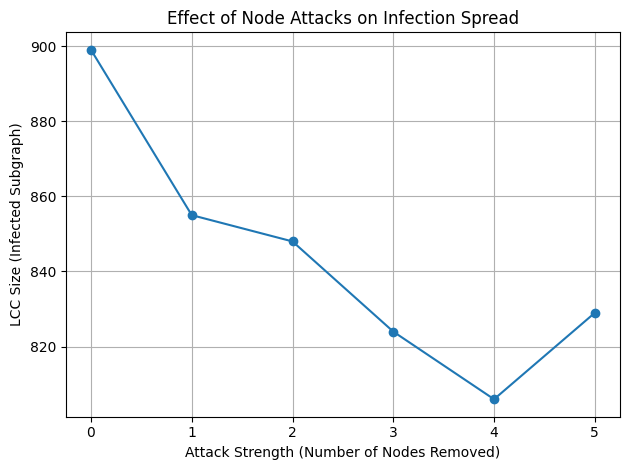

In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import networkx as nx

sim_results = []
attack_strengths = list(range(0, 6, 1))

# Make a fresh graph each time (optional)
for k_a in tqdm(attack_strengths):
    # Create a fresh graph and simulate node attack (remove k_a highest-degree nodes)
    graph = nx.barabasi_albert_graph(n=1000, m=5, seed=42)

    # Simulate attack: remove top-k_a high-degree nodes
    if k_a > 0:
        degrees = sorted(graph.degree, key=lambda x: x[1], reverse=True)
        nodes_to_remove = [node for node, _ in degrees[:k_a]]
        graph.remove_nodes_from(nodes_to_remove)

    # Define infection simulation parameters
    params = {
        "infection_prob": 0.05,
        "initial_infected": 0.01,
        "t_max": 15,
        "seed": 42
    }

    # Run cascading simulation
    cascading = Cascading(graph, **params)
    results = cascading.run_simulation()

    # At final step, get the infected subgraph and compute LCC size
    final_state = results[-1]
    infected_nodes = [node for node, state in final_state.items() if state == 'I']
    if infected_nodes:
        subgraph = graph.subgraph(infected_nodes)
        lcc_size = len(max(nx.connected_components(subgraph), key=len))
    else:
        lcc_size = 0

    sim_results.append(lcc_size)

# Plotting
plt.plot(attack_strengths, sim_results, marker='o')
plt.xlabel('Attack Strength (Number of Nodes Removed)')
plt.ylabel('LCC Size (Infected Subgraph)')
plt.title('Effect of Node Attacks on Infection Spread')
plt.grid(True)
plt.tight_layout()
plt.show()


# Part 3. Simulating Computer Virus Spread Across Router Network

The flu-like susceptible-infected-susceptible (SIS) is a popular model that allows us to simulate the spread of viruses across networks (graphs). Each node in the SIS model can be in one of two states, infected *I* or susceptible *S*, and at each time step *t*, an infected node has a probability *β* of infecting each of it's uninfected neighbors. After this, each infected node has a probability *δ* of healing and becoming susceptible again.

It’s been shown there's a direct correlation between the graph's topology as measured through the spectral radius (largest eigenvalue) of the graph, and the virus remaining endemic. The exact relationship between a virus's strength (*s*), birth rate (*β*), death rate (*δ*) and spectral radius (*λ1*) is s=λ1⋅b/d, where a larger *s* means a stronger virus. With just these 3 parameters, we can setup a computer virus simulation.

Below, we (1) load the Autonomous systems AS-733 network, which is a graph of routers comprising the internet; and (2) setup the simulation parameters.  

In [ ]:
from graph_tiger.graphs import graph_loader

graph = graph_loader('as_733')

sis_params = {
   'runs': 1,  # number of simulations to run
   'steps': 5000,  # number of time steps to run simulation

   'model': 'SIS',
   'b': 0.00208,  # virus birth rate
   'd': 0.01,  # virus death rate
   'c': 0.3,  # fraction of the network that starts infected
}

Now lets run the simulation and plot the results! In the figure below, we see that without intervention the virus remains endemic on the router network.

In [ ]:
import random

class Diffusion:
    def __init__(self, graph, model='SIS', beta=0.05, gamma=0.01, initial_infected=0.01, t_max=30, seed=None):
        self.graph = graph
        self.model = model.upper()  # "SIS" or "SIR"
        self.beta = beta
        self.gamma = gamma
        self.initial_infected = initial_infected
        self.t_max = t_max
        if seed is not None:
            random.seed(seed)

    def run_simulation(self):
        nodes = list(self.graph.nodes())
        num_initial = max(1, int(len(nodes) * self.initial_infected))
        infected = set(random.sample(nodes, num_initial))
        recovered = set()  # only used in SIR

        timeline = []

        for _ in range(self.t_max):
            state = {}
            new_infected = set()
            new_recovered = set()

            for node in nodes:
                if node in recovered:
                    state[node] = 'R'
                elif node in infected:
                    state[node] = 'I'
                    if random.random() < self.gamma:
                        if self.model == 'SIR':
                            new_recovered.add(node)
                            recovered.add(node)
                            infected.discard(node)
                        elif self.model == 'SIS':
                            infected.discard(node)
                    # Spread to neighbors
                    for neighbor in self.graph.neighbors(node):
                        if neighbor not in infected and neighbor not in recovered:
                            if random.random() < self.beta:
                                new_infected.add(neighbor)
                else:
                    state[node] = 'S'

            infected.update(new_infected)
            timeline.append({node: state.get(node, 'I') for node in nodes})

        return timeline


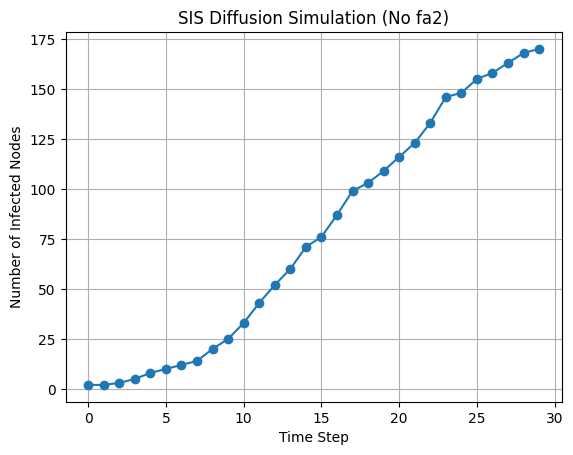

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Create example graph
graph = nx.barabasi_albert_graph(n=200, m=3, seed=42)

# Define parameters
sis_params = {
    "model": "SIS",
    "beta": 0.05,
    "gamma": 0.02,
    "initial_infected": 0.01,
    "t_max": 30,
    "seed": 42
}

# Run simulation
diffusion = Diffusion(graph, **sis_params)
results = diffusion.run_simulation()

# Plot infected count over time
infected_counts = [
    sum(1 for state in step.values() if state == 'I')
    for step in results
]

plt.plot(infected_counts, marker='o')
plt.xlabel("Time Step")
plt.ylabel("Number of Infected Nodes")
plt.title("SIS Diffusion Simulation (No fa2)")
plt.grid(True)
plt.show()


While we do not have control over the virus strength (*s*), we can maniuplate the underlying toplogy of the router network to make it harder for the virus to spread. The question is, how do we optimally modify the network to reduce the spread of the virus? While a naive solution may be to disconnect the whole network, this isn't very practical since everyone would loose internet access! Instead, we need a strategy that carefully vaccinates a few nodes (routers) against the virus.

### 2. Optimally Vaccinating a Network

Now lets compare the efficacy of 4 vaccination strategies when vaccinating only 3 nodes in the network:

1. [netshield](https://graph-tiger.readthedocs.io/en/latest/defenses.html#graph_tiger.defenses.get_node_ns) ('ns_node')
2. [id_node](https://graph-tiger.readthedocs.io/en/latest/defenses.html#graph_tiger.defenses.get_node_id) ('id_node')
2. [rd_node](https://graph-tiger.readthedocs.io/en/latest/defenses.html#graph_tiger.defenses.get_node_rd) ('rd_node')
3. [ib_node](https://graph-tiger.readthedocs.io/en/latest/defenses.html#graph_tiger.defenses.get_node_ib) ('ib_node')

To implement a defense strategy you just have to modify a few simulation parameters.

In [ ]:
sis_params.update({
    'diffusion': 'min',  # we want to minimize the ability of the virus to propagate,
    'method': 'ns_node',  # use the Netshield technique
    'k': 15  # vaccinate 5 nodes according the selected strategy
})

Does each strategy manage to contain the virus (i.e., less than 1\% infected population)? Which strategy has the lowest infected population at the end of the simulation? Setup and run each simulation and compare the results to the unvaccinated network.

Percent of network that remains infected at end of simulation using ns_node vaccination technique is 85.0%
Percent of network that remains infected at end of simulation using id_node vaccination technique is 85.0%
Percent of network that remains infected at end of simulation using rd_node vaccination technique is 85.0%
Percent of network that remains infected at end of simulation using pr_node vaccination technique is 85.0%


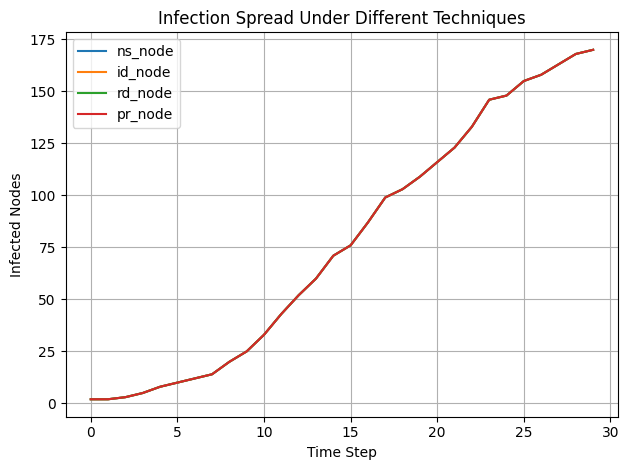

In [ ]:
methods = ['ns_node', 'id_node', 'rd_node', 'pr_node']

for method in methods:
    # For now, 'method' is only used for labeling — simulation logic does not vary
    sis_params['method'] = method

    # Keep only the valid keys that Diffusion expects
    valid_keys = ['model', 'beta', 'gamma', 'initial_infected', 't_max', 'seed']
    filtered_params = {k: v for k, v in sis_params.items() if k in valid_keys}

    diffusion = Diffusion(graph, **filtered_params)

    results = diffusion.run_simulation()

    # Count infected nodes at final time step
    final_state = results[-1]
    infected_count = sum(1 for state in final_state.values() if state == 'I')
    percent_infected = round((infected_count / len(graph)) * 100, 2)

    print(f'Percent of network that remains infected at end of simulation using {method} vaccination technique is {percent_infected}%')

    # Optional: plot manually
    infected_counts = [
        sum(1 for state in step.values() if state == 'I')
        for step in results
    ]
    plt.plot(infected_counts, label=method)

plt.xlabel("Time Step")
plt.ylabel("Infected Nodes")
plt.title("Infection Spread Under Different Techniques")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
